In [1]:
from glob import glob
import os.path as op
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

In [2]:
import nibabel as nib
from nibabel.streamlines import load as load_trk
import dipy.tracking.streamline as dts
import dipy.tracking.utils as dtu
from skimage.transform import resize
from scipy.ndimage.morphology import binary_dilation
import dipy.data as dpd
from sklearn.utils import class_weight

In [3]:
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [4]:
import bundlenet as bn

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import dask.bag as db

In [7]:
ls /home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles

AF_L.trk             CCMid.trk  CST_R.trk   IFOF_L.trk
AF_R.trk             C_L.trk    F_L.trk     MCP.trk
CC_ForcepsMajor.trk  C_R.trk    F_R.trk     UF_L.trk
CC_ForcepsMinor.trk  CST_L.trk  IF0F_R.trk  UF_R.trk


In [8]:
bundle_files = sorted(glob('/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/*.trk'))

In [9]:
diff_img = nib.load('/home/ubuntu/MNI152_T1_1mm_brain.nii.gz')
vol_shape=diff_img.shape[0:3]
vol_shape

(182, 218, 182)

In [10]:
bundle_files

['/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/AF_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/AF_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CCMid.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CC_ForcepsMajor.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CC_ForcepsMinor.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CST_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CST_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/C_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/C_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/F_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/F_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/IF0F_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/IFOF_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/MCP.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/UF_L.trk',
 '/home/ubuntu/A

In [11]:
n_streamlines = []
bundle_names = []
for fname in bundle_files:
    bundle_names.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])
    streamlines = bn.read_sl(fname) 
    n_streamlines.append(len(streamlines))


In [12]:
np.min(n_streamlines), len(n_streamlines)

(72, 16)

In [13]:
n_streamlines

[2010,
 1145,
 525,
 365,
 565,
 2528,
 2470,
 1890,
 2185,
 72,
 106,
 2393,
 1228,
 1690,
 370,
 328]

In [20]:
take_n_bundles = len(n_streamlines)
take_n_sl = np.min(n_streamlines)

test_perc=0
val_perc=0.2
size_slimage = 100

In [21]:
import imp  
imp.reload(bn)
streamlines_loaded = db.from_sequence(bundle_files).map(bn.read_sl_mni).compute()
streamlines_processed = db.from_sequence(streamlines_loaded).map(bn.process_sl_onedirection,take_n_sl,vol_shape,size_slimage,2).compute() 
data_train_0, data_test_0, data_val_0, labels_train_0, labels_test_0, labels_val_0 = bn.partition_testtrain_onedirection(test_perc, val_perc, streamlines_processed,0)
data_train_1, data_test_1, data_val_1, labels_train_1, labels_test_1, labels_val_1 = bn.partition_testtrain_onedirection(test_perc, val_perc, streamlines_processed,1)
data_train_2, data_test_2, data_val_2, labels_train_2, labels_test_2, labels_val_2 = bn.partition_testtrain_onedirection(test_perc, val_perc, streamlines_processed,2)

labels_train_0_cat = keras.utils.to_categorical(labels_train_0, take_n_bundles)
labels_val_0_cat  = keras.utils.to_categorical(labels_val_0, take_n_bundles)
labels_test_0_cat  = keras.utils.to_categorical(labels_test_0, take_n_bundles)

labels_train_1_cat = keras.utils.to_categorical(labels_train_1, take_n_bundles)
labels_val_1_cat  = keras.utils.to_categorical(labels_val_1, take_n_bundles)
labels_test_1_cat  = keras.utils.to_categorical(labels_test_1, take_n_bundles)

labels_train_2_cat = keras.utils.to_categorical(labels_train_2, take_n_bundles)
labels_val_2_cat  = keras.utils.to_categorical(labels_val_2, take_n_bundles)
labels_test_2_cat  = keras.utils.to_categorical(labels_test_2, take_n_bundles)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


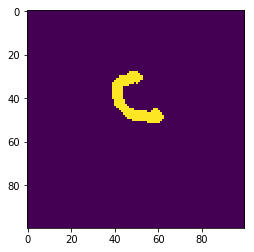

In [16]:
plt.imshow(streamlines_processed[10][2][1,:,:,0])

In [22]:
img_rows = size_slimage
img_cols = size_slimage
batch_size = 4
epochs = 20
num_classes = take_n_bundles
input_shape = (img_rows, img_cols,1)

In [26]:
data_aug = 0

Train on 921 samples, validate on 231 samples
Epoch 1/20
921/921 [==============================] - 4s 4ms/step - loss: 0.8239 - acc: 0.6992 - val_loss: 0.4564 - val_acc: 0.7835
Epoch 2/20
921/921 [==============================] - 3s 3ms/step - loss: 0.4682 - acc: 0.7883 - val_loss: 0.4923 - val_acc: 0.7403
Epoch 3/20
921/921 [==============================] - 3s 3ms/step - loss: 0.3571 - acc: 0.8426 - val_loss: 0.3203 - val_acc: 0.8398
Epoch 4/20
921/921 [==============================] - 3s 3ms/step - loss: 0.2908 - acc: 0.8654 - val_loss: 0.3349 - val_acc: 0.8485
Epoch 5/20
921/921 [==============================] - 3s 3ms/step - loss: 0.2890 - acc: 0.8730 - val_loss: 0.3227 - val_acc: 0.8485
Epoch 6/20
921/921 [==============================] - 3s 3ms/step - loss: 0.2642 - acc: 0.8860 - val_loss: 0.2852 - val_acc: 0.8701
Epoch 7/20
921/921 [==============================] - 3s 3ms/step - loss: 0.2263 - acc: 0.9023 - val_loss: 0.3475 - val_acc: 0.8312
Epoch 8/20
921/921 [==========

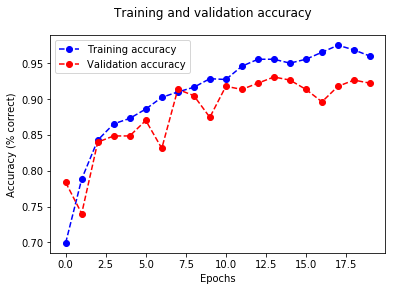

In [24]:
import imp  
imp.reload(bn)
model_0 = bn.trainmodel(data_train_0, labels_train_0_cat, labels_train_0, data_val_0, labels_val_0_cat, data_test_0, labels_test_0_cat, input_shape, num_classes, batch_size, epochs, data_aug, 2000)

Train on 921 samples, validate on 231 samples
Epoch 1/20
921/921 [==============================] - 4s 4ms/step - loss: 0.2985 - acc: 0.9110 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 2/20
921/921 [==============================] - 3s 3ms/step - loss: 0.0386 - acc: 0.9870 - val_loss: 9.3180e-04 - val_acc: 1.0000
Epoch 3/20
921/921 [==============================] - 3s 3ms/step - loss: 0.0362 - acc: 0.9891 - val_loss: 0.0092 - val_acc: 0.9957
Epoch 4/20
921/921 [==============================] - 3s 3ms/step - loss: 0.0248 - acc: 0.9946 - val_loss: 7.9706e-04 - val_acc: 1.0000
Epoch 5/20
921/921 [==============================] - 3s 3ms/step - loss: 5.7869e-04 - acc: 1.0000 - val_loss: 8.3843e-06 - val_acc: 1.0000
Epoch 6/20
921/921 [==============================] - 3s 3ms/step - loss: 1.2050e-04 - acc: 1.0000 - val_loss: 3.9114e-06 - val_acc: 1.0000
Epoch 7/20
921/921 [==============================] - 3s 3ms/step - loss: 1.0616e-04 - acc: 1.0000 - val_loss: 1.9995e-06 - val_acc: 1.000

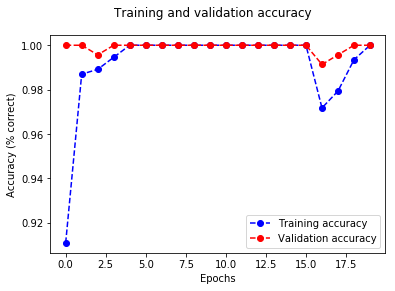

In [27]:
model_1 = bn.trainmodel(data_train_1, labels_train_1_cat, labels_train_1, data_val_1, labels_val_1_cat, data_test_1, labels_test_1_cat, input_shape, num_classes, batch_size, epochs, data_aug, 2000)

Train on 921 samples, validate on 231 samples
Epoch 1/20
921/921 [==============================] - 4s 4ms/step - loss: 0.2934 - acc: 0.9045 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 2/20
921/921 [==============================] - 3s 3ms/step - loss: 0.0153 - acc: 0.9957 - val_loss: 1.7955e-04 - val_acc: 1.0000
Epoch 3/20
921/921 [==============================] - 3s 3ms/step - loss: 9.6893e-04 - acc: 1.0000 - val_loss: 1.6848e-04 - val_acc: 1.0000
Epoch 4/20
921/921 [==============================] - 3s 3ms/step - loss: 9.4416e-04 - acc: 1.0000 - val_loss: 3.5782e-05 - val_acc: 1.0000
Epoch 5/20
921/921 [==============================] - 3s 3ms/step - loss: 0.0191 - acc: 0.9978 - val_loss: 0.0064 - val_acc: 1.0000
Epoch 6/20
921/921 [==============================] - 3s 3ms/step - loss: 0.0926 - acc: 0.9805 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 7/20
921/921 [==============================] - 3s 3ms/step - loss: 0.0184 - acc: 0.9924 - val_loss: 0.0078 - val_acc: 0.9957
Epoch 8/20

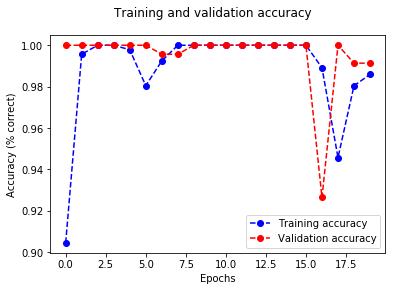

In [28]:
model_2 = bn.trainmodel(data_train_2, labels_train_2_cat, labels_train_2, data_val_2, labels_val_2_cat, data_test_2, labels_test_2_cat, input_shape, num_classes, batch_size, epochs, data_aug, 2000)

In [29]:
sub2_t1_img = nib.load('/home/ubuntu/MNI152_T1_1mm_brain.nii.gz')
vol_shape_subj2=sub2_t1_img.shape[0:3]
vol_shape_subj2

(182, 218, 182)

In [30]:
streamlines_all = bn.read_sl_mni('/home/ubuntu/recobundles/100307/out_work/whole_brain_MNI_tracks_from_sh__moved.trk') 

In [31]:
#get the indicdes that correspond to bundles in streamlines_all
map_files = sorted(glob('/home/ubuntu/recobundles/100307/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_*.npy'))
map_file_index = []
labels_s1 = []
for m_idx, m in enumerate(map_files):
    tmp = np.load(m)
    map_file_index = np.append(map_file_index,tmp)
    labels_s1 = np.append(labels_s1,m_idx*np.ones([len(tmp),1]))
labels_s1

array([ 0.,  0.,  0., ..., 15., 15., 15.])

In [32]:
#get an equal number of unlabelled streamlines
ind = range(len(streamlines_all))
ind = np.delete(ind,map_file_index)
np.random.shuffle(ind)
unlabeled_streamlines = ind[0:len(map_file_index)]
labels_s1 = np.append(labels_s1,16*np.ones([len(map_file_index),1]))

In [33]:
np.append(map_file_index,unlabeled_streamlines)

array([186748., 199724., 199806., ...,  40121., 160100.,   2108.])

In [34]:
streamlines_all_sub = [streamlines_all[i] for i in np.int_(np.append(map_file_index,unlabeled_streamlines))]
len(streamlines_all_sub)
len(labels_s1)

57386

In [35]:
import imp  
imp.reload(bn)
streamlines_all_processed = bn.process_sl_onedirection(streamlines_all_sub,-1,vol_shape_subj2,size_slimage,2)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000


In [36]:
p_s1_0 = model_0.predict(streamlines_all_processed[0], batch_size=5)

In [37]:
p_s1_1 = model_1.predict(streamlines_all_processed[1], batch_size=5)

In [38]:
p_s1_2 = model_2.predict(streamlines_all_processed[2], batch_size=5)

(array([ 1936., 12441.,  4415.,  4830.,   639.,   722.,  1238.,  1333.,
         1047., 28785.]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <a list of 10 Patch objects>)

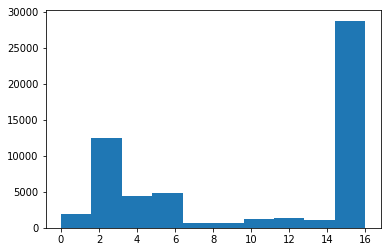

In [39]:
plt.hist(labels_s1)

In [40]:
p_idx = np.argmax(p_s1_0, axis=-1)
p_idx_all = p_idx
bn.print_accuarcystats(p_idx[labels_s1<16],labels_s1[labels_s1<16])

Percent correct is 0.8455720907538424 
Kappa is: 0.8130992355595756
Jaccard is: 0.8455720907538424


In [41]:
p_idx = np.argmax(p_s1_1, axis=-1)
p_idx_all = np.column_stack((p_idx_all, p_idx))
bn.print_accuarcystats(p_idx[labels_s1<16],labels_s1[labels_s1<16])

Percent correct is 0.9667166207785871 
Kappa is: 0.9597925554778515
Jaccard is: 0.9667166207785871


In [42]:
p_idx = np.argmax(p_s1_2, axis=-1)
p_idx_all = np.column_stack((p_idx_all, p_idx))
bn.print_accuarcystats(p_idx[labels_s1<16],labels_s1[labels_s1<16])

Percent correct is 0.9541700066218242 
Kappa is: 0.9448857298292371
Jaccard is: 0.9541700066218242


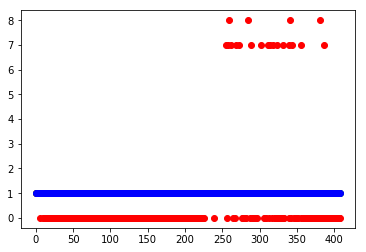

In [43]:
labels_s1==2
bund0 = p_idx_all[labels_s1==1,:]
bund0
plt.plot(bund0[:,0], 'ro',bund0[:,1], 'go',bund0[:,2], 'bo')

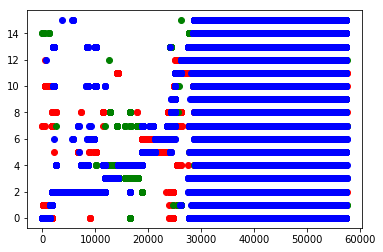

In [44]:
plt.plot(p_idx_all[:,0], 'ro',p_idx_all[:,1], 'go',p_idx_all[:,2], 'bo')

In [45]:
len(np.unique(p_idx_all[0,:]))

2

In [46]:
unique_vals = np.zeros((len(p_idx_all),1))
for i in range(len(p_idx_all)):
    unique_vals[i] = len(np.unique(p_idx_all[i,:]))
unique_vals

array([[2.],
       [1.],
       [1.],
       ...,
       [3.],
       [3.],
       [3.]])

In [47]:
perc_onelabel = np.zeros((17,1))
perc_twolabel = np.zeros((17,1))
perc_threelabel = np.zeros((17,1))

for i in range(17):
    ind = labels_s1 == i
    perc_onelabel[i] = np.sum(unique_vals[ind]==1)/np.sum(ind)
    perc_twolabel[i] = np.sum(unique_vals[ind]==2)/np.sum(ind)
    perc_threelabel[i] = np.sum(unique_vals[ind]==3)/np.sum(ind)

In [48]:
perc_onelabel

array([[0.80681074],
       [0.22982885],
       [0.93346084],
       [0.92381332],
       [0.93023783],
       [0.66693101],
       [0.38691508],
       [0.43035994],
       [0.80834621],
       [0.05333333],
       [0.92647059],
       [0.59709619],
       [0.6264066 ],
       [0.472     ],
       [0.60465116],
       [0.32608696],
       [0.12916042]])

In [49]:
perc_twolabel

array([[0.1918795 ],
       [0.77017115],
       [0.0619086 ],
       [0.07618668],
       [0.06432616],
       [0.32910389],
       [0.61308492],
       [0.55242567],
       [0.18547141],
       [0.77333333],
       [0.07352941],
       [0.36206897],
       [0.3735934 ],
       [0.40114286],
       [0.36046512],
       [0.67391304],
       [0.45690587]])

In [50]:
perc_threelabel

array([[0.00130976],
       [0.        ],
       [0.00463056],
       [0.        ],
       [0.00543601],
       [0.00396511],
       [0.        ],
       [0.0172144 ],
       [0.00618238],
       [0.17333333],
       [0.        ],
       [0.04083485],
       [0.        ],
       [0.12685714],
       [0.03488372],
       [0.        ],
       [0.41393371]])

In [51]:
t = np.concatenate((p_s1_0,p_s1_1,p_s1_2),axis=1)

In [52]:
t.shape

(57386, 48)

In [53]:
np.save('allprob_noaug.npy',t)

In [54]:
labels_s1.shape

(57386,)

In [55]:
np.save('labels_noaug.npy',labels_s1)